# 1. Imports e configs e constantes 

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
TARGET_COL = "y"
ID_COL = "id"
TIME_COL = "safra"

In [4]:
pd.set_option("display.max_columns", 100)

# 2. Ler bases

In [5]:
df_train = pd.read_csv(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\data\processed\train_fe.csv')
df_test  = pd.read_csv(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\data\processed\test_fe.csv')

# 3. Separar X e y

In [6]:
cols_not_features = [TARGET_COL, ID_COL, TIME_COL]

feature_cols = [c for c in df_train.columns if c not in cols_not_features]

X_train = df_train[feature_cols].copy()
y_train = df_train[TARGET_COL].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test[TARGET_COL].copy()

X_train.shape, X_test.shape

((8211, 47), (2527, 47))

# 4. Identificar numéricas e categóricas

In [7]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_features[:10], categorical_features[:10]

(['VAR_1',
  'VAR_2',
  'VAR_3',
  'VAR_4',
  'VAR_5',
  'VAR_6',
  'VAR_7',
  'VAR_8',
  'VAR_9',
  'VAR_10'],
 [])

# 5. Imputação + Normalização + Dummies

In [8]:
# Transformador numérico: imputação pela mediana + padronização
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Transformador categórico: imputação + OneHot
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

transformers = []
if len(numeric_features) > 0:
    transformers.append(("num", numeric_transformer, numeric_features))
if len(categorical_features) > 0:
    transformers.append(("cat", categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
)

In [9]:
X_train_prepared = preprocessor.fit_transform(X_train, y_train)
X_test_prepared  = preprocessor.transform(X_test)

X_train_prepared.shape, X_test_prepared.shape

((8211, 47), (2527, 47))

# 6. Seleção de variáveis com random forest

In [ ]:
# Pegando as variaveis e transformando em DataFrame
feature_names_num = numeric_features

if len(categorical_features) > 0:
    ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
    feature_names_cat = ohe.get_feature_names_out(categorical_features).tolist()
else:
    feature_names_cat = []

feature_names_prepared = feature_names_num + feature_names_cat

X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=feature_names_prepared)
X_test_prepared_df  = pd.DataFrame(X_test_prepared,  columns=feature_names_prepared)

X_train_prepared_df.shape, X_test_prepared_df.shape

((8211, 47), (2527, 47))

In [ ]:
# Criando o modelo
rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample",  # ajuda com desbalanceamento
)

rf_clf.fit(X_train_prepared_df, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Classificando por importância
importances = rf_clf.feature_importances_

feat_importances = (
    pd.Series(importances, index=feature_names_prepared)
      .sort_values(ascending=False)
)

feat_importances.head(20)

VAR_1     0.072854
VAR_6     0.041128
VAR_9     0.037998
VAR_57    0.035119
VAR_72    0.034969
VAR_3     0.033827
VAR_65    0.033282
VAR_4     0.032870
VAR_53    0.031283
VAR_30    0.030014
VAR_27    0.029464
VAR_2     0.027448
VAR_54    0.027136
VAR_17    0.025582
VAR_20    0.025148
VAR_38    0.022708
VAR_5     0.022415
VAR_24    0.021725
VAR_7     0.021227
VAR_34    0.021131
dtype: float64

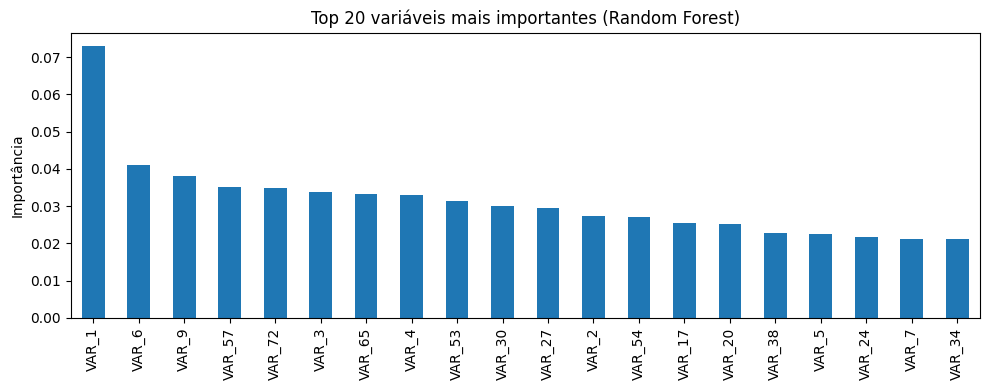

In [ ]:
# Plotando gráfico
top_n = 20

feat_importances.head(top_n).plot(kind="bar", figsize=(10, 4))
plt.title(f"Top {top_n} variáveis mais importantes (Random Forest)")
plt.ylabel("Importância")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:
# Selecionando varíaveis
top_k = 20  

selected_features = feat_importances.head(top_k).index.tolist()

X_train_sel = X_train_prepared_df[selected_features].copy()
X_test_sel  = X_test_prepared_df[selected_features].copy()

X_train_sel.shape, X_test_sel.shape

((8211, 20), (2527, 20))

# 7. Cross-Validation

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'XGBoost':             XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM':            LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42)
}

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_rows = []

for name, base_model in models.items():
    ks_scores = []
    auc_scores = []
    gini_scores = []

    print(f"Rodando CV para: {name}")

    for train_idx, val_idx in cv.split(X_train_sel, y_train):
        X_tr = X_train_sel.iloc[train_idx]
        X_val = X_train_sel.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model = clone(base_model)
        model.fit(X_tr, y_tr)

        y_proba_val = model.predict_proba(X_val)[:, 1]
        ks, auc, gini = performance_metrics(y_val, y_proba_val)

        ks_scores.append(ks)
        auc_scores.append(auc)
        gini_scores.append(gini)

    cv_rows.append({
        "Modelo":     name,
        "KS Médio":   np.mean(ks_scores),
        "KS Desvio":  np.std(ks_scores, ddof=1),
        "AUC Médio":  np.mean(auc_scores),
        "AUC Desvio": np.std(auc_scores, ddof=1),
        "Gini Médio": np.mean(gini_scores),
        "Gini Desvio":np.std(gini_scores, ddof=1),
    })

df_cv = (
    pd.DataFrame(cv_rows)
      .sort_values("AUC Médio", ascending=False)
      .reset_index(drop=True)
)

print("=== Resultados Cross-Validation - Treino ===")
display(df_cv)

Rodando CV para: Logistic Regression
Rodando CV para: Random Forest
Rodando CV para: XGBoost


c:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:07:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:07:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:07:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\venv\Lib\site-pac

Rodando CV para: LightGBM
[LightGBM] [Info] Number of positive: 1852, number of negative: 4716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3861
[LightGBM] [Info] Number of data points in the train set: 6568, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281973 -> initscore=-0.934695
[LightGBM] [Info] Start training from score -0.934695
[LightGBM] [Info] Number of positive: 1853, number of negative: 4716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 6569, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.282083 -> initscore=-0.934155
[LightGBM] [Info] Start training from score -0

,Modelo,KS Médio,KS Desvio,AUC Médio,AUC Desvio,Gini Médio,Gini Desvio
0,Random Forest,0.443456,0.024193,0.792102,0.010102,0.584205,0.020204
1,LightGBM,0.426390,0.025728,0.786589,0.015673,0.573178,0.031346
2,Logistic Regression,0.425663,0.014956,0.785328,0.011366,0.570655,0.022732
3,XGBoost,0.432470,0.029269,0.782955,0.018935,0.565910,0.037869


In [41]:
test_rows = []

for name, base_model in models.items():
    print(f"Treinando modelo final: {name}")
    model = clone(base_model)
    model.fit(X_train_sel, y_train)

    y_proba_test = model.predict_proba(X_test_sel)[:, 1]
    ks_t, auc_t, gini_t = performance_metrics(y_test, y_proba_test)

    test_rows.append({
        "Modelo": name,
        "KS":     ks_t,
        "AUC":    auc_t,
        "Gini":   gini_t,
    })

df_test = (
    pd.DataFrame(test_rows)
      .sort_values("AUC", ascending=False)
      .reset_index(drop=True)
)

print("\n=== Resultados Finais - Teste ===")
display(df_test)

Treinando modelo final: Logistic Regression
Treinando modelo final: Random Forest
Treinando modelo final: XGBoost


c:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:08:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Treinando modelo final: LightGBM
[LightGBM] [Info] Number of positive: 2316, number of negative: 5895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3865
[LightGBM] [Info] Number of data points in the train set: 8211, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.282061 -> initscore=-0.934263
[LightGBM] [Info] Start training from score -0.934263

=== Resultados Finais - Teste ===


,Modelo,KS,AUC,Gini
0,Logistic Regression,0.291797,0.700697,0.401395
1,Random Forest,0.297436,0.696005,0.392010
2,LightGBM,0.284362,0.689321,0.378643
3,XGBoost,0.266115,0.665928,0.331856


In [42]:
import joblib

# lista de colunas selecionadas
selected_features = X_train_sel.columns.tolist()

joblib.dump(selected_features, r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\models\selected_features.pkl')

['C:\\Users\\Enrico\\OneDrive\\Documentos\\Python\\credit_scoring_challenge\\models\\selected_features.pkl']

# Funções Métricas

In [39]:
def ks_score(y_true, y_proba) -> float:
    data = pd.DataFrame({"y": y_true, "score": y_proba}).sort_values(
        "score", ascending=False
    )

    total_bad = (data["y"] == 1).sum()
    total_good = (data["y"] == 0).sum()

    if total_bad == 0 or total_good == 0:
        return 0.0

    data["cum_bad"] = (data["y"] == 1).cumsum() / total_bad
    data["cum_good"] = (data["y"] == 0).cumsum() / total_good

    ks = (data["cum_bad"] - data["cum_good"]).abs().max()
    return float(ks)


def performance_metrics(y_true, y_proba):
    auc = roc_auc_score(y_true, y_proba)
    ks = ks_score(y_true, y_proba)
    gini = 2 * auc - 1
    return ks, auc, gini